# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [14]:
# Load pickled data
import pickle

# The training/testing files are too large to include in source control. 
# Download them from https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [15]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

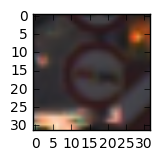

In [16]:
# Picks a random training set image and shows it on a coordinate plot

import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(1.5,1.5))

index = random.randint(0, len(X_train))
plt.imshow(X_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
# Preprocessing
# Shuffles the training data and segments off a validation set

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

# Shuffle the training samples & labels
X_train, y_train = shuffle(X_train, y_train)

# Carve out 20% of the training set to use as a validtion set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))



Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


In [18]:
# Network architecture - a modification of the LeNet architecture. 
# My modifications:
#   - Add additional convolutional layer (3 convolutional layers total) 
#   - Deeper convolutional layers. (output depths: 32, 64, 128)
#   - Add additional fully connected layer (3 fully connected layers total)
#   - Dropout between convolutional and fully connected layers to mitigate overfitting

from tensorflow.contrib.layers import flatten
import tensorflow as tf

# Hyperparameters
EPOCHS = 35
BATCH_SIZE = 500
MU = 0
SIGMA = 0.1
RATE = 0.001

# Convolutional layer
def conv(x, width, height, in_depth, out_depth):    
    shape = (width, height, in_depth, out_depth)
    conv_W = tf.Variable(tf.truncated_normal(shape=shape, mean = MU, stddev = SIGMA))
    conv_b = tf.Variable(tf.zeros(out_depth))
    conv_out = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b

    # Activation.
    conv_out = tf.nn.relu(conv_out)

    # Pooling
    return tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Fully connected layer
def fully_connected(x, input_shape, output_shape):
    fc_W = tf.Variable(tf.truncated_normal(shape=(input_shape, output_shape), mean = MU, stddev = SIGMA))
    fc_b = tf.Variable(tf.zeros(output_shape))
    fc = tf.matmul(x, fc_W) + fc_b
    
    return tf.nn.relu(fc)

# Modified LeNet architecture
def LeNet(x):    

    # Layer 1: Convolutional. Input = 32x32x3. Output = 29x29x32. Pooling = 14x14x32
    conv1 = conv(x, 4, 4, 3, 32)
    
    # Layer 2: Convolutional. Input = 14x14x32. Output = 11x11x64. Pooling = 5x5x64
    conv2 = conv(conv1, 4, 4, 32, 64)
    
    # Layer 3: Convolutional. Input = 5x5x64. Output = 4x4x128. Pooling = 2x2x128
    conv3 = conv(conv2, 2, 2, 64, 128)
    
    # Flatten. Input = 2x2x128. Output = 512.
    flat = flatten(conv3)
    
    # Dropout
    dropout = tf.nn.dropout(flat, keep_prob)
    
    # Layer 4: Fully Connected. Input = 512. Output = 200.
    fc1 = fully_connected(dropout, 512, 200)
    
    # Layer 5: Fully Connected. Input = 200. Output = 75.
    fc1 = fully_connected(fc1, 200, 75)

    # Layer 6: Fully Connected. Input = 75. Output = 43.
    logits = fully_connected(fc1, 75, 43)
    
    return logits

In [19]:
# Evaluate accuracy of model. Used for both validation and test sets
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
# Placeholder Tensors
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

# One hot encode labels
one_hot_y = tf.one_hot(y, 43)

# Get logits and minimize error
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #Shuffle data with for each epoch
        X_train, y_train = shuffle(X_train, y_train)
        
        #Divide samples into batches, run each through neural net
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
        
        #Calculate accuracy based on validation set
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} - Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
       
    #Save model
    saver.save(sess, 'lenet')
    print()
    print("Model saved")

Training...

EPOCH 1 - Validation Accuracy = 0.085
EPOCH 2 - Validation Accuracy = 0.188
EPOCH 3 - Validation Accuracy = 0.311
EPOCH 4 - Validation Accuracy = 0.398
EPOCH 5 - Validation Accuracy = 0.508
EPOCH 6 - Validation Accuracy = 0.590
EPOCH 7 - Validation Accuracy = 0.676
EPOCH 8 - Validation Accuracy = 0.740
EPOCH 9 - Validation Accuracy = 0.800
EPOCH 10 - Validation Accuracy = 0.845
EPOCH 11 - Validation Accuracy = 0.864
EPOCH 12 - Validation Accuracy = 0.893
EPOCH 13 - Validation Accuracy = 0.908
EPOCH 14 - Validation Accuracy = 0.923
EPOCH 15 - Validation Accuracy = 0.922
EPOCH 16 - Validation Accuracy = 0.935
EPOCH 17 - Validation Accuracy = 0.941
EPOCH 18 - Validation Accuracy = 0.951
EPOCH 19 - Validation Accuracy = 0.958
EPOCH 20 - Validation Accuracy = 0.964
EPOCH 21 - Validation Accuracy = 0.966
EPOCH 22 - Validation Accuracy = 0.964
EPOCH 23 - Validation Accuracy = 0.969
EPOCH 24 - Validation Accuracy = 0.970
EPOCH 25 - Validation Accuracy = 0.967
EPOCH 26 - Validation

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

My preprocessing step is pretty simple. It just shuffles the training set.
For further experimentation I can try grayscaling or augumenting the images.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
The training set is provided and I did not modify it.
My validation consists of 20% of the training set . We need to use a validation set while tuning our model to ensure that we're not overfitting

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
 My network architecture is a modification of the LeNet architecture. 
 My modifications:
   - Add additional convolutional layer (3 convolutional layers total) 
   - Deeper convolutional layers
   - Add additional fully connected layer (3 fully connected layers total)
   - Dropout between convolutional and fully connected layers to mitigate overfitting
   
Layer 1: Convolutional. Input = 32x32x3. Output = 29x29x32. Pooling = 14x14x32  
Layer 2: Convolutional. Input = 14x14x32. Output = 11x11x64. Pooling = 5x5x64  
Layer 3: Convolutional. Input = 5x5x64. Output = 4x4x128. Pooling = 2x2x128  
Data is then flattened into 1D array of 512 elements  
50% dropout applied  
Layer 4: Fully Connected. Input = 512. Output = 200.  
Layer 5: Fully Connected. Input = 200. Output = 75.  
Layer 6: Fully Connected. Input = 75. Output = 43.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  
Hyperparameters: 
epochs = 35  
batch size = 500  
initial weight mean = 0  
initial weight std dev = 0.1  
learning rate = 0.001  
  
I used the Adam Optimizer instead of Gradient Descent as the optimizer


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started by plugging in the LeNet architecture used in the LeNet lab earlier in the course. From there it was a combination of trial and error and some critical thinking. 

At the beginning, I just started to play around with the hyperparameters to see how that would affect the network. Here I observed that increasing the learning rate produced a jittery network where the accuracy would fluctuate wildly. Also increasing the standard deviation lowered the accuracy significantly. 

Next I recalled that each layer of a convolutional network is used to identify groupings of attributes about an image. Adding more layers allows us to identify more groupings. In addition, increasing the depth of each layer increases the number of unique attributes that can be identified.

I added a dropout operation to prevent overfitting. This really helped the accuracy go up.

I also added another connected layer to see if this would function similar to adding more convolutional layers. Mainly this just decreased the learning speed. However, increasing the number of epochs really helped here. 

In the end, I experimented with the sizes of each layer/filter to see how this would change the accuracy

With the given model & architecutre, I was able to get ~98% accuracy for the validation set and ~94.5 for the test set

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.938


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [26]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
%matplotlib inline

candidate_images = []
candidate_labels = [40, 2, 22, 17, 28]
candidate_names = ["Roundabout mandatory", "Speed limit 50km/h", "Bumpy road", "No entry", "Children crossing"]

def loadImage(filename):
    img = cv2.imread("candidateImages/"+filename, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])  # switch to rgb
    candidate_images.append(rgb_img)

loadImage("roundabout.png") #40
loadImage("50_speed.png") #2
loadImage("bumps.png") #22
loadImage("noentry.png") #17
loadImage("childrencrossing.png") #28

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(candidate_images, candidate_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
With the couple runs I've done, I get between 60% - 80% accuracy. A couple things could be affecting these results. First, many of these images are stock photos and have watermarks over parts of the images, which is distoring the sign. Also, the images aren't cut with the same specifications of the training data. The training images have consistent padding around all 4 sides of the image. Some of my images don't have the same padding. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [27]:
softmax = tf.nn.softmax(logits)
top3 = tf.nn.top_k(softmax, k = 3)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = sess.run(top3, feed_dict={x: candidate_images, y: candidate_labels, keep_prob:1.0})
    
    i = 0
    for probabilities, labels, candidate_name in zip(output[0], output[1], candidate_names):
        print("{}:".format(candidate_names[i]))
        for probability, label in zip(probabilities, labels):
            print("\t label {} - probability {:.3f}".format(label, probability))
        print("\n")
        i += 1



Roundabout mandatory:
	 label 40 - probability 1.000
	 label 34 - probability 0.000
	 label 35 - probability 0.000


Speed limit 50km/h:
	 label 5 - probability 0.907
	 label 2 - probability 0.089
	 label 1 - probability 0.003


Bumpy road:
	 label 22 - probability 1.000
	 label 29 - probability 0.000
	 label 24 - probability 0.000


No entry:
	 label 17 - probability 1.000
	 label 14 - probability 0.000
	 label 9 - probability 0.000


Children crossing:
	 label 28 - probability 0.991
	 label 30 - probability 0.004
	 label 23 - probability 0.000




**Analysis**

Here's a sample output that my model generated:
```
Roundabout mandatory:
	 label 40 - probability 1.000
	 label 34 - probability 0.000
	 label 35 - probability 0.000

Speed limit 50km/h:
	 label 5 - probability 0.907
	 label 2 - probability 0.089
	 label 1 - probability 0.003

Bumpy road:
	 label 22 - probability 1.000
	 label 29 - probability 0.000
	 label 24 - probability 0.000

No entry:
	 label 17 - probability 1.000
	 label 14 - probability 0.000
	 label 9 - probability 0.000

Children crossing:
	 label 28 - probability 0.991
	 label 30 - probability 0.004
	 label 23 - probability 0.000

```

Looks my model was able to correctly classify the roundabout, bumpy road, no entry, and children crossing candidate images with high confidence.

What's interesting is that the 50km/h sign was actually predicted to be a 80km/h with fairly high certainty (~91%). My thinking is that the model is mixing up 5 and 8 because they look similar. I re-computed the weights several times without changing any of the code and found that my model frequently fails to classify the speed limit sign correctly. The neural net usually identifies that it's a speed limit sign, but struggles to detect the exact speed limit amount. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.